In [1]:
# imports 


import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import copy
from torchvision import transforms
import torch
import csv
import random
import numpy as np
from PIL import Image 
from tqdm import tqdm

import sys
sys.path.append(r'/home/afroehli/coding/util_scripts')
from utils_dataloading.dassl_datum_mod import DatumWithWnid 
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

sys.path.append(r'/home/afroehli/coding/OOD-X-Benchmarks')
from datasets import imagenet_x as i_x, imagenet_r_x as r_x, imagenet_c_x as c_x, imagenet_v2_x as v2_x

# other setup
random.seed(3)

In [4]:

# load model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.eval()
dinov2_vits14.to(device)

transform = transforms.Compose([transforms.Resize((154, 210)),
                                transforms.ToTensor()])


# load semantic-info object
with open(r'/home/afroehli/coding/pickle_data/imagenet_semantic_info.pkl', 'rb') as pkl_file:
    semantic_info = pickle.load(pkl_file)


# load classes that are common in all imagenet variances 
wnids_common_classes = set()
with open('/home/afroehli/coding/dinov2_ood/storage/union_set_classes.txt', 'r') as union_file: 
    for line in union_file.readlines():
        common_wnid = line.rstrip('\n')
        wnids_common_classes.add(common_wnid)

print(f'Common classes found: {len(wnids_common_classes)}')
for n, common_class_wnid in enumerate(wnids_common_classes): 
    print(f'{n + 1}: {semantic_info.wnid_to_classname[common_class_wnid]}') 

# only in case model output was stored before
# load already calculated embeddings

datasets_dict = {
        'imagenet_x': {'filename': 'imagenet_x_val_results.pkl', 'sorted_classes': None, 'model_results' : None}, 
        'imagenet_r': {'filename': 'imagenet_r_results.pkl', 'sorted_classes': None, 'model_results': None}, 
        'imagenet_v2': {'filename': 'imagenet_v2_results.pkl', 'sorted_classes': None, 'model_results': None}, 
        'imagenet_c': {'filename': 'imagenet_c_results.pkl', 'sorted_classes': None, 'model_results': None}
}

with open('/home/afroehli/coding/pickle_data/dinov2_ood_datasets_dict.pkl', 'rb') as pickle_file:
    datasets_dict = pickle.load(pickle_file)

for dataset_name in datasets_dict.keys():
    try:
        if datasets_dict[dataset_name]['sorted_classes'] == None:
            print(f'Try to load dataset: {dataset_name}')
            with open(f'/home/afroehli/coding/pickle_data/dataset_objects/{dataset_name}_sorted.pkl', 'rb') as pickle_file: 
                datasets_dict[dataset_name]['sorted_classes'] = pickle.load(pickle_file)
    except FileNotFoundError:
        print(f'Dataset-file was not found: {dataset_name}_sorted.pkl')
        datasets_dict[dataset_name]['sorted_classes'] = None

    try:
        if datasets_dict[dataset_name]['model_results'] == None:
            print(f'Try to load model-results for: {dataset_name}')
            model_results_fname = f'/home/afroehli/coding/pickle_data/model_output/{datasets_dict[dataset_name]['filename']}'
            with open(model_results_fname, 'rb') as pickle_file:
                datasets_dict[dataset_name]['model_results'] = pickle.load(pickle_file)
    except FileNotFoundError: 
        print(f'Model-results file could not be found: {model_results_fname}')
        datasets_dict[dataset_name]['model_results'] = None



model_res_loaded = [dset for dset in datasets_dict.keys() if datasets_dict[dset]['model_results'] !=  None]
model_res_not_loaded = [dset for dset in datasets_dict.keys() if datasets_dict[dset]['model_results'] ==  None]

print(f'Following datasets were loaded: {model_res_loaded}')
print(f'Following datasets are missing: {model_res_not_loaded}')






Device used: cuda


Using cache found in /home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main


Common classes found: 135
1:  cheetah
2:  monarch butterfly
3:  Beagle
4:  basketball
5:  hyena
6:  barn
7:  tabby cat
8:  bee
9:  Golden Retriever
10:  Chow Chow
11:  llama
12:  axolotl
13:  bucket
14:  beer glass
15:  porcupine
16:  bathtub
17:  lion
18:  West Highland White Terrier
19:  Scottish Terrier
20:  lorikeet
21:  goldfish
22:  pig
23:  chimpanzee
24:  bald eagle
25:  goose
26:  fly
27:  dragonfly
28:  starfish
29:  chameleon
30:  Boxer
31:  Afghan Hound
32:  gazelle
33:  great white shark
34:  zebra
35:  castle
36:  candle
37:  Pembroke Welsh Corgi
38:  hen
39:  king penguin
40:  tarantula
41:  snow leopard
42:  lighthouse
43:  orangutan
44:  ostrich
45:  Basset Hound
46:  hermit crab
47:  Dalmatian
48:  binoculars
49:  Whippet
50:  goldfinch
51:  tiger
52:  carousel
53:  Cocker Spaniel
54:  Standard Poodle
55:  Toy Poodle
56:  pelican
57:  Shih Tzu
58:  Yorkshire Terrier
59:  pug
60:  polar bear
61:  skunk
62:  Italian Greyhound
63:  sea lion
64:  grey wolf
65:  red fox
66

In [ ]:
# compute closest class for each common class 

# for each common-class, find closest class in rest of imagenet-1k (999 candidates)

common_class_comparisons = dict()
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected common-wnids: {len(wnids_common_classes)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for common_wnid in wnids_common_classes:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[common_wnid], axis=0)

    imagenet_wnids.remove(common_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            common_class_comparisons[common_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            common_class_comparisons[common_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    common_class_comparisons[common_wnid].sort(key = lambda ood_id: ood_id[0])
    imagenet_wnids.append(common_wnid)

Number of detected common-wnids: 135
Number of detected imagenet-wnids: 1000


In [7]:
# control output of closest classes 

for n, common_wnid in enumerate(common_class_comparisons.keys()):

    top_three = common_class_comparisons[common_wnid][:3]
    top_three_names = [(semantic_info.wnid_to_classname[tt_wnid], tt_score) for tt_score, tt_wnid in top_three]
    print(f'{n}: CC-Class = {semantic_info.wnid_to_classname[common_wnid]}, Next classes = {top_three_names}')

0: CC-Class =  chimpanzee, Next classes = [(' gorilla', np.float32(235.94043)), (' siamang', np.float32(286.9928)), (' orangutan', np.float32(309.70462))]
1: CC-Class =  Basset Hound, Next classes = [(' Beagle', np.float32(261.91693)), (' Treeing Walker Coonhound', np.float32(276.79465)), (' English foxhound', np.float32(339.79163))]
2: CC-Class =  giant panda, Next classes = [(' American black bear', np.float32(472.17554)), (' sloth bear', np.float32(484.3158)), (' brown bear', np.float32(489.51086))]
3: CC-Class =  Pomeranian, Next classes = [(' Chow Chow', np.float32(366.84155)), (' Pekingese', np.float32(401.38516)), (' Keeshond', np.float32(410.54218))]
4: CC-Class =  beaver, Next classes = [(' otter', np.float32(317.88696)), (' marmot', np.float32(359.8711)), (' mink', np.float32(389.43878))]
5: CC-Class =  Cocker Spaniel, Next classes = [(' Irish Setter', np.float32(292.4155)), (' Sussex Spaniel', np.float32(298.002)), (' Clumber Spaniel', np.float32(362.87933))]
6: CC-Class =  

In [10]:
# store class split 

with open('/home/afroehli/coding/dinov2_ood/storage/class_split.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for common_wnid in common_class_comparisons.keys():
        closest_class_wnid = common_class_comparisons[common_wnid][0][1]
        split_writer.writerow([common_wnid, closest_class_wnid])


In [5]:
# load class pairs 

closest_classes = set() 
    

with open('/home/afroehli/coding/dinov2_ood/storage/class_split.csv', 'r')as class_split_table:
    split_reader = csv.reader(class_split_table, delimiter=';')
    for n, table_row in enumerate(split_reader):
        class_1 = table_row[0]
        class_2 = table_row[1]
        new_combination = (class_1, class_2)
        closest_classes.add(new_combination)



In [6]:
# util functions  

def get_random_class() -> str:
    all_classes = list(datasets_dict['imagenet_x']['sorted_classes'].keys())
    n_classes = len(all_classes)
    next_int = random.randint(0, n_classes - 1)
    next_class = all_classes[next_int]

    return next_class

In [4]:
# variables for later use

ood_id_random_combination = []
random_compare_set = dict()


# data type of precomputed results 

print(type(datasets_dict['imagenet_x']['model_results']['n01440764'][0]))

<class 'numpy.ndarray'>


In [ ]:
# calculate embedding for new classes 

datasets_dict['imagenet_r']['model_results'] = None

batch_size = 10

total_imgs_processed = 0
total_batches = 0

for dataset_name in datasets_dict.keys():
        
        if datasets_dict[dataset_name]['model_results'] == None:

            model_results = dict()

            print(f'Next calculate results for dataset: {dataset_name}')
            dataset = datasets_dict[dataset_name]['sorted_classes']

            dataset_wnids = list(dataset.keys())

            for wnid in (pbar := tqdm(dataset_wnids, ncols=100)):

                n_imgs_to_batch = 0

                batch_list = []
                for batch_start in range(0, len(dataset[wnid]), batch_size):
                    class_sublist = dataset[wnid][batch_start:batch_start + batch_size]
                    next_batch = [transform(Image.open(class_item.impath).convert('RGB')).unsqueeze(0).to(device) for class_item in class_sublist]
                    batch_list.append(torch.cat(next_batch))

                    n_imgs_to_batch += len(next_batch)
                         
                # over all batches
                for n, batch in enumerate(batch_list): 

                    model_out = dinov2_vits14(batch)
                    try: 
                        model_results[wnid].extend(list(model_out.cpu().detach().numpy()))
                    except KeyError:
                        model_results[wnid] = list(model_out.cpu().detach().numpy())

                total_imgs_processed += n_imgs_to_batch 
                total_batches += len(batch_list)

            # assign temporory model-result storage to general result dictionary
            datasets_dict[dataset_name]['model_results'] = model_results 

print(f'Number of processed images: {total_imgs_processed}')
print(f'Number of processed batches: {total_batches}')


Next calculate results for dataset: imagenet_r


100%|█████████████████████████████████████████████████████████████| 200/200 [03:26<00:00,  1.03s/it]

Number of processed images: 30000
Number of processed batches: 3088


In [13]:
# check if new batch calculation is same as old calculation 

not_same_emb = 0 
same_emb = 0 
mean_not_equal = 0

for wnid in imagenet_v2_results_test.keys():

    total_test = len(imagenet_v2_results_test[wnid])
    type_test = type(imagenet_v2_results_test[wnid])

    total_expected = len(datasets_dict['imagenet_v2']['model_results'][wnid])
    type_expected = type(datasets_dict['imagenet_v2']['model_results'][wnid])

    if total_test != total_expected:
        print(f'Different number of embeddings for: {wnid}, Test = {total_test}, Exp = {total_expected}')
        break 
    if type_test != type_expected:
        print(f'Different types between results for: {wnid}, Test-type = {type_test}, Exp-type = {type_expected}')
        break 
    
    mean_test = np.mean(np.array(imagenet_v2_results_test[wnid]), axis = 0)
    mean_exp = np.mean(np.array(datasets_dict['imagenet_v2']['model_results'][wnid]), axis = 0)

    try:
        np.testing.assert_array_almost_equal(mean_test, mean_exp, decimal=6)
    except AssertionError:
        mean_not_equal += 1
    
    for n, emb in enumerate(imagenet_v2_results_test[wnid]):

        test_emb = emb 
        expected_emb = datasets_dict['imagenet_v2']['model_results'][wnid][n]

        type_test_emb = type(test_emb)
        type_exp_emb = type(expected_emb)

        if type_test_emb != type_exp_emb: 
            print(f'Different types for embeddings for: {wnid}, Test-emb-type = {type_test_emb}, Exp-emb-type = {type_exp_emb}')
            break 

        if not np.array_equal(test_emb, expected_emb):
            # print(f'Not same embeddings. \nTest-emb = {test_emb}\nExpe-emb = {expected_emb}')
            not_same_emb += 1 
        else: 
            same_emb += 1 
        
print(f'Mean not equal: {mean_not_equal}')
print(f'Embedding was same: {same_emb}, was not same: {not_same_emb}')

Mean not equal: 1000
Embedding was same: 0, was not same: 10000


In [7]:
# Check dimensions of result sets 

print(f'Number of calculated classes for Imagenet-X, Expected 1000, Acutal: {len(list(datasets_dict['imagenet_x']['model_results']))}')
print(f'Number of calculated classes for Imagenet-V2, Expected 1000, Actual: {len(list(datasets_dict['imagenet_v2']['model_results']))}')
print(f'Number of calculated classes for Imagenet-C:, Expected  521, Actual: {len(list(datasets_dict['imagenet_c']['model_results']))}')
print(f'Number of calculated classes for Imagenet-R:, Expected  200, Actual: {len(list(datasets_dict['imagenet_r']['model_results']))}')

#print(datasets_dict['imagenet_r']['model_results'])
# print(datasets_dict['imagenet_c']['model_results'])
print(datasets_dict['imagenet_r']['model_results'].keys())
# print(datasets_dict['imagenet_r']['model_results']['n10565667'])

Number of calculated classes for Imagenet-X, Expected 1000, Acutal: 1000
Number of calculated classes for Imagenet-V2, Expected 1000, Actual: 1000
Number of calculated classes for Imagenet-C:, Expected  521, Actual: 521
Number of calculated classes for Imagenet-R:, Expected  200, Actual: 200
dict_keys(['n01484850', 'n01494475', 'n01531178', 'n01614925', 'n01630670', 'n01644373', 'n01677366', 'n01806143', 'n01820546', 'n01833805', 'n01860187', 'n01944390', 'n01983481', 'n02007558', 'n02009912', 'n02051845', 'n02071294', 'n02077923', 'n02085620', 'n02088094', 'n02088238', 'n02088364', 'n02088466', 'n02091032', 'n02094433', 'n02108089', 'n02110341', 'n02110958', 'n02112018', 'n02113023', 'n02113624', 'n02114367', 'n02117135', 'n02119022', 'n02123045', 'n02128385', 'n02128757', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02233338', 'n02268443', 'n02317335', 'n02325366', 'n02346627', 'n02364673', 'n02391049', 'n02395406', 'n02398521', 'n02410509', 'n02480495', 'n02483362', 'n02486

In [8]:
# store calculated classes

for dataset_name in datasets_dict.keys():

    if datasets_dict[dataset_name]['model_results'] != None:
        filename = f'/home/afroehli/coding/pickle_data/model_output/{datasets_dict[dataset_name]['filename']}'
        with open(filename, 'wb') as pickle_file:
            pickle.dump(datasets_dict[dataset_name]['model_results'], pickle_file, pickle.HIGHEST_PROTOCOL)


In [9]:


## calculate statistics 

# general statistics on whole imagenet dataset 

# np-array with shape 1000 x 50 x 384
results_all_classes = np.array([datasets_dict['imagenet_x']['model_results'][class_wnid] for class_wnid in datasets_dict['imagenet_x']['model_results'].keys()])

mean_pictures_all_classes = np.mean(results_all_classes, axis=1)
mean_classes_all_classes = np.mean(mean_pictures_all_classes, axis=0)
mean_imagenet = mean_classes_all_classes # shape 384

statistics_dict = dict()

for inv_class, comp_class in closest_classes: 

    comb_key = (inv_class, comp_class)

    # select random compare class
    ran_comp_class = get_random_class()
    while ran_comp_class == inv_class or ran_comp_class == comp_class:
        ran_comp_class = get_random_class()

    statistics_dict[comb_key] = dict()
    statistics_dict[comb_key]['ran_comp_class'] = ran_comp_class 

    # statistics on invariant class
    inv_class_res = np.array(datasets_dict['imagenet_x']['model_results'][inv_class])
    inv_class_mean = np.mean(inv_class_res, axis=0)
    inv_class_std = np.std(inv_class_res, axis=0)

    # statistics on most similar compare class
    comp_class_res = np.array(datasets_dict['imagenet_x']['model_results'][comp_class])
    comp_class_mean = np.mean(comp_class_res, axis=0) 
    comp_class_std = np.std(comp_class_res, axis=0)
    diff_comp_inv = np.abs(comp_class_mean - inv_class_mean)

    statistics_dict[comb_key] = dict()
    statistics_dict[comb_key]['counts'] = dict()
    statistics_dict[comb_key]['inSTD'] = dict()
    statistics_dict[comb_key]['sum'] = dict()

    # save statistics of compare class
    true_false_list = (diff_comp_inv < inv_class_std).tolist()
    comp_within_std = true_false_list.count(True)
    statistics_dict[comb_key]['inSTD']['comp'] = comp_within_std

    statistics_dict[comb_key]['sum']['comp'] = np.sum(diff_comp_inv)


    # calculate statistics for all other datasets and classes 
    for d_name, d_short, d_wnid in [('imagenet_x', 'inet', ''), ('imagenet_x', 'ranComp', ran_comp_class), 
                                    ('imagenet_r', 'inetR', inv_class), ('imagenet_v2', 'inetV2', inv_class), 
                                    ('imagenet_c', 'inetC', inv_class)]: 

        if d_short != 'inet':
            d_results = np.array(datasets_dict[d_name]['model_results'][d_wnid])

        if d_short != 'inet':
            d_result_mean = np.mean(d_results, axis = 0)
        else: 
            d_result_mean = mean_classes_all_classes

        if d_short != 'inet':
            d_result_std = np.std(d_results, axis = 0)

        diff_to_inv = np.abs(d_result_mean - inv_class_mean)

        # count dimensions where mean of class1 is nearer than of class2 
        true_false_list = (diff_comp_inv < diff_to_inv).tolist()
        comp_is_nearer = true_false_list.count(True)
        statistics_dict[comb_key]['counts']['comp-' + d_short] = comp_is_nearer 

        # count dimensions where mean of class1 lies within std of inv-class
        true_false_list = (diff_to_inv < inv_class_std).tolist()
        counts_within_std = true_false_list.count(True)
        statistics_dict[comb_key]['inSTD'][d_short] = counts_within_std

        # sum of p1-distance over all dimensions
        statistics_dict[comb_key]['sum'][d_short] = np.sum(diff_to_inv)




In [14]:
# prepare statistics 

all_combinations = list(statistics_dict.keys())
comb_mapping = dict()
for n, comb in enumerate(all_combinations):
    comb_mapping[n] = comb 

all_combinations_numbers = list(comb_mapping.keys())

# data for utilizing visualization

fifty_percent = [50 for i in range(0, len(all_combinations))]
fifty_percent_df = pd.DataFrame(data=list(zip(all_combinations_numbers, fifty_percent)), columns=['Comb', 'Val'])
fifty_percent_df['Rel'] = '50%'

# generating dataframes for visualizing smaller distance counts
dfs_counts = [fifty_percent_df]
for count_type in ['comp-ranComp', 'comp-inet', 'comp-inetR', 'comp-inetV2', 'comp-inetC']:
    relative_counts = [(statistics_dict[combination]['counts'][count_type] / 384) * 100 for combination in all_combinations]
    relative_counts_df = pd.DataFrame(data=list(zip(all_combinations_numbers, relative_counts)), columns=['Comb', 'Val'])
    relative_counts_df['Rel'] = count_type

    dfs_counts.append(relative_counts_df)

diff_counts_df = pd.concat(dfs_counts, ignore_index=True)

# generating dataframes for visualizing sum over distances per dimension

dfs_sums = [fifty_percent_df]
for sum_type in ['comp', 'ranComp', 'inet', 'inetR', 'inetV2', 'inetC']:

    sum_diff = [statistics_dict[combination]['sum'][sum_type] for combination in all_combinations]
    mean_sum_diff = [sum(sum_diff) / 135 for i in range(0, 135)]
    sum_diff_df = pd.DataFrame(data = list(zip(all_combinations_numbers, sum_diff, mean_sum_diff)), 
                                columns=['Comb', 'Sum', 'MeanSum'])
    sum_diff_df['Rel'] = sum_type

    dfs_sums.append(sum_diff_df)


diff_sum_df = pd.concat(dfs_sums, ignore_index=True)

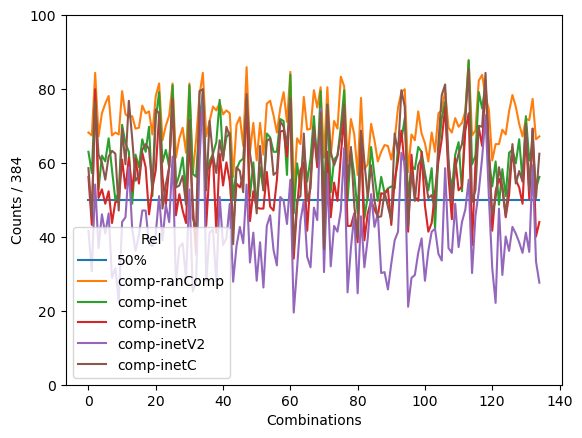

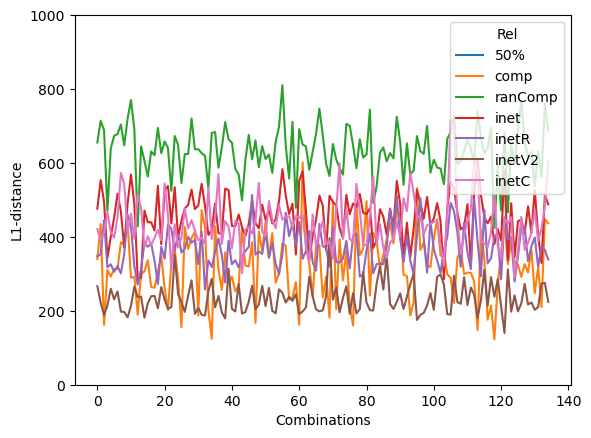

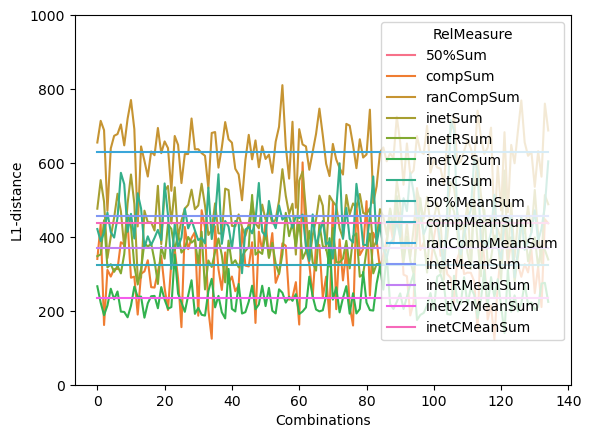

In [17]:
 # visualize statistics 

plt.ylim(0,100)
ax = sns.lineplot(data=diff_counts_df, x='Comb', y='Val', hue='Rel')
ax.set(xlabel = 'Combinations', ylabel= 'Counts / 384')
plt.show()

plt.ylim(0,1000)
ax = sns.lineplot(data=diff_sum_df, x='Comb', y='Sum', hue='Rel')
ax.set(xlabel='Combinations', ylabel='L1-distance')
plt.show()

sum_mean_combined = diff_sum_df.melt(id_vars=['Comb', 'Rel'], var_name='Measure', value_vars=['Sum', 'MeanSum'])
sum_mean_combined['RelMeasure'] = sum_mean_combined['Rel'] + sum_mean_combined['Measure']

plt.ylim(0,1000)
ax = sns.lineplot(data=sum_mean_combined, x='Comb', y='value', hue='RelMeasure', legend=True)
ax.set(xlabel='Combinations', ylabel='L1-distance')
plt.show()

In [41]:
# identify 50% of worst id-ood matches regarding mean distance 
# 

sum_combination_dict = dict()

for combination in all_combinations:
    sum_combination_dict[float(statistics_dict[combination]['id_sum'])] = combination 

sorted_dict = sorted(sum_combination_dict)
print(sorted_dict)

worst_id_ood_matches = []
for p, diff_sum in enumerate(sorted_dict):

    ood_wnid, id_wnid, ran_wnid = sum_combination_dict[diff_sum]
    id_name = semantic_info.wnid_to_classname[id_wnid]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]

    print(f'{p}: Scored {diff_sum:.2e}: OOD = {ood_name}, ID = {id_name}')

print(f'Combinations printed: {len(sorted_dict)} from possible {len(all_combinations)} combinations.')

[285.52801513671875, 289.4336853027344, 292.9093017578125, 306.568359375, 309.7046203613281, 342.04351806640625, 364.65673828125, 364.68670654296875, 366.841552734375, 384.62213134765625, 399.7071838378906, 410.1962890625, 426.5854797363281, 427.532958984375, 434.56048583984375, 445.22161865234375, 470.74700927734375, 488.12548828125, 493.9937744140625, 502.389892578125, 508.62213134765625, 517.4906005859375, 528.6527099609375, 531.45068359375, 536.09912109375, 544.8900146484375, 554.5610961914062, 560.0919189453125, 565.3636474609375, 585.909912109375, 601.3419189453125, 618.6402587890625, 628.5443115234375, 641.086669921875, 641.65869140625, 643.666015625, 645.576904296875, 674.760986328125, 693.0130615234375, 693.08740234375]
0: Scored 2.86e+02: OOD =  Standard Poodle, ID =  Toy Poodle
1: Scored 2.89e+02: OOD =  cheetah, ID =  leopard
2: Scored 2.93e+02: OOD =  Whippet, ID =  Italian Greyhound
3: Scored 3.07e+02: OOD =  gorilla, ID =  orangutan
4: Scored 3.10e+02: OOD =  chimpanzee,

In [ ]:
# for each ood-class, find closest class in rest of imagenet-1k (999 candidates)

ood_class_comparisons = dict()
all_ood_wnids = [id_ood[0] for id_ood in class_splits]
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected ood-wnids: {len(all_ood_wnids)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for ood_wnid in all_ood_wnids:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[ood_wnid], axis=0)

    imagenet_wnids.remove(ood_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            ood_class_comparisons[ood_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            ood_class_comparisons[ood_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    ood_class_comparisons[ood_wnid].sort(key = lambda ood_id: ood_id[0])
    
    imagenet_wnids.append(ood_wnid)

Number of detected ood-wnids: 40
Number of detected imagenet-wnids: 1000
Total compare classes for n01616318: 999
Total compare classes for n02106550: 999
Total compare classes for n02096585: 999
Total compare classes for n02112137: 999
Total compare classes for n02091134: 999
Total compare classes for n02086240: 999
Total compare classes for n02056570: 999
Total compare classes for n02480855: 999
Total compare classes for n01534433: 999
Total compare classes for n02749479: 999
Total compare classes for n02108915: 999
Total compare classes for n02481823: 999
Total compare classes for n01694178: 999
Total compare classes for n02236044: 999
Total compare classes for n02423022: 999
Total compare classes for n02113799: 999
Total compare classes for n02814860: 999
Total compare classes for n01632777: 999
Total compare classes for n01986214: 999
Total compare classes for n02097298: 999
Total compare classes for n02098286: 999
Total compare classes for n02066245: 999
Total compare classes for

In [50]:
# print closest compare classes for each ood-class

for ood_wnid in all_ood_wnids: 

    top_five = ood_class_comparisons[ood_wnid][:5]
    top_five_names = [(semantic_info.wnid_to_classname[wnid], score) for score, wnid in top_five]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]
    print(f'OOD = {ood_name}: {top_five_names}')


OOD =  vulture: [(' bald eagle', np.float32(364.6867)), (' kite (bird of prey)', np.float32(374.1024)), (' hornbill', np.float32(427.8051)), (' ptarmigan', np.float32(438.59735)), (' black stork', np.float32(446.6934))]
OOD =  Rottweiler: [(' Black and Tan Coonhound', np.float32(247.84436)), (' Dobermann', np.float32(274.29382)), (' Miniature Pinscher', np.float32(354.40723)), (' Greater Swiss Mountain Dog', np.float32(369.6695)), (' Entlebucher Sennenhund', np.float32(377.0548))]
OOD =  Boston Terrier: [(' French Bulldog', np.float32(313.06226)), (' Staffordshire Bull Terrier', np.float32(401.3598)), (' Boxer', np.float32(438.5884)), (' American Staffordshire Terrier', np.float32(439.02612)), (' toy terrier', np.float32(443.41534))]
OOD =  Chow Chow: [(' Pomeranian', np.float32(366.84155)), (' Keeshond', np.float32(374.4064)), (' Samoyed', np.float32(429.12982)), (' Pekingese', np.float32(445.51138)), (' Great Pyrenees dog', np.float32(469.20425))]
OOD =  Whippet: [(' Ibizan Hound', n